In [22]:
import io
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyclustering
import requests
import scipy.sparse as sparse
import seaborn as sns

from graph_tool.all import *
from math import comb
from pyclustering.cluster.kmedians import kmedians
from scipy.sparse import coo_matrix
from sklearn import cluster, metrics

# SBM Noise Matrices

In [5]:
def get_coo_matrix(G, symmetric=False):
    nnodes = G.num_vertices()

    rows = []
    cols = []
    data = []

    for e in G.edges():
        src = e.source()
        tgt = e.target()
        rows.append(src)
        cols.append(tgt)
        data.append(1)  # unweighted graph

        if symmetric:
        # For undirected graphs
            rows.append(tgt)
            cols.append(src)
            data.append(1)

    # Create the adjacency matrix in COO format
    adj_matrix_coo = coo_matrix((data, (rows, cols)), shape=(nnodes, nnodes))
    return adj_matrix_coo

def calc_all_densities(adj_matrix, block_list):

    block_labels, block_sizes = np.unique(block_list, return_counts=True)
    nblocks = len(block_labels)
    density_matrix = np.zeros((nblocks, nblocks))

    for i, j, v in zip(adj_matrix.row, adj_matrix.col, adj_matrix.data):
        density_matrix[block_list[i], block_list[j]] += 1

    for i in range(len(block_labels)):
        for j in range(len(block_labels)):
            density_matrix[block_labels[i],
                           block_labels[j]] = np.max([density_matrix[block_labels[i],
                                                                     block_labels[j]], 1])/(block_sizes[i]*block_sizes[j])

    return(density_matrix)

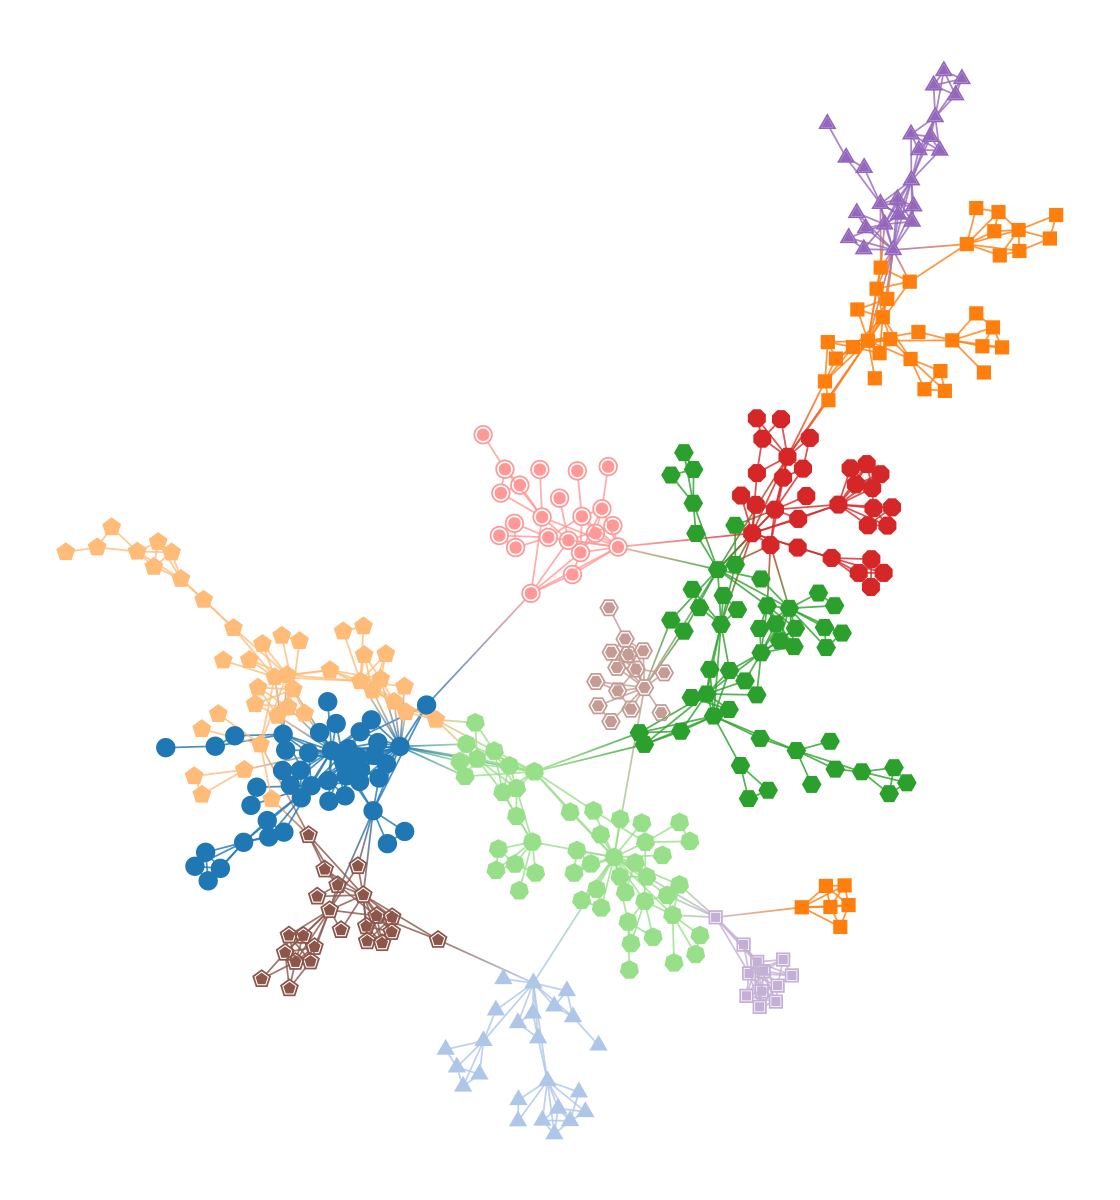

<GraphView object, undirected, with 379 vertices and 914 edges, 2 internal vertex properties, 1 internal edge property, 2 internal graph properties, at 0x309579770>


In [6]:
# Load graph
# G = collection.ns['power'] #['football'] #["uni_email"]     #['cond-mat'] #   #

G = collection.data['netscience']  # ['polblogs']
G = extract_largest_component(G, prune=True)

remove_parallel_edges(G)
remove_self_loops(G)
G= GraphView(G, directed=False)


# Inference of blockstate
state = minimize_blockmodel_dl(G,  multilevel_mcmc_args={'niter':2})
b = contiguous_map(state.get_blocks())
state = state.copy(b=b)
block_list = state.get_blocks().a
adj_matrix = get_coo_matrix(G)
density_matrix = calc_all_densities(adj_matrix, block_list)


# draw
pos = sfdp_layout(G, groups=state.get_blocks(), gamma=0.0000001)
state.draw(pos=pos, vertex_shape=state.get_blocks())

print(G)

In [12]:
def add_SBM(adj_matrix, block_list, density_matrix, epsilon):

    W_01 = np.zeros_like(density_matrix)
    W_11 = np.zeros_like(density_matrix)
    N_C = np.zeros_like(density_matrix)

    block_labels, block_sizes = np.unique(block_list, return_counts=True)
    for i in range(len(block_labels)):
        for j in range(len(block_labels)):
            p_00, p_11 = prob_from_eps_density(epsilon, density_matrix[i,j])
            N_C[i,j] = block_sizes[block_labels[i]]*block_sizes[block_labels[j]]
            W_01[i,j] = int((1-p_00)*N_C[i,j])
            W_11[i,j] = int(p_11*N_C[i,j])

    np.fill_diagonal(W_11, W_11.diagonal()*2)    # diagonal should have twice the avg num of edges

    g_keep = generate_sbm(block_list, W_11, micro_ers=True)
    m_keep = get_coo_matrix(g_keep, symmetric=True)

    M_keep = adj_matrix.multiply(m_keep)
    M_keep.tocoo().data = np.ones_like(M_keep.tocoo().data)
    print(m_keep.sum(), M_keep.sum(), adj_matrix.sum())


    g_add = generate_sbm(block_list, W_01)
    m_add = get_coo_matrix(g_add, symmetric=True)


    # prompt: generate a sparse coo matrix with the pairs in m_add but not in M

    # Find pairs present in m_add but not in M
    m_add_pairs = set(zip(m_add.row, m_add.col))
    M_pairs = set(zip(adj_matrix.row, adj_matrix.col))

    pairs_in_m_add_not_in_M = list(m_add_pairs - M_pairs)

    # Create a sparse COO matrix from the identified pairs
    rows = [pair[0] for pair in pairs_in_m_add_not_in_M]
    cols = [pair[1] for pair in pairs_in_m_add_not_in_M]
    data = [1] * len(rows)  # Assuming a value of 1 for the new matrix

    M_add = sparse.coo_matrix((data, (rows, cols)), shape=adj_matrix.shape)

    Noisy_M = M_add + M_keep
    Noisy_M = Noisy_M.tocoo()
    # NoisyG = coo_matrix_to_graphtool(Noisy_M)
    # NoisyG
    return(Noisy_M)

def prob_from_eps_density(epsilon, density):
    density = max(density, 1e-10)  # or any small positive value
    denom = (np.exp(epsilon)- 1 + (1/density))
    z = 1/denom
    v = (1 - z, np.exp(epsilon) * z)  # vector v=(p_00, p_11) that preserves Sparseness and Epsilon-LDP
    # print(v)
    return v

def coo_matrix_to_graphtool(coo_matrix):
    g = Graph(directed=False)  # Create an undirected graph
    g.add_vertex(coo_matrix.shape[0])

    for i, j, v in zip(coo_matrix.row, coo_matrix.col, coo_matrix.data):
        g.add_edge(g.vertex(i), g.vertex(j))

    remove_parallel_edges(g)
    remove_self_loops(g)
    return g

# Figure

2812 223 914
<Graph object, undirected, with 379 vertices and 553 edges, at 0x31cad5d90>


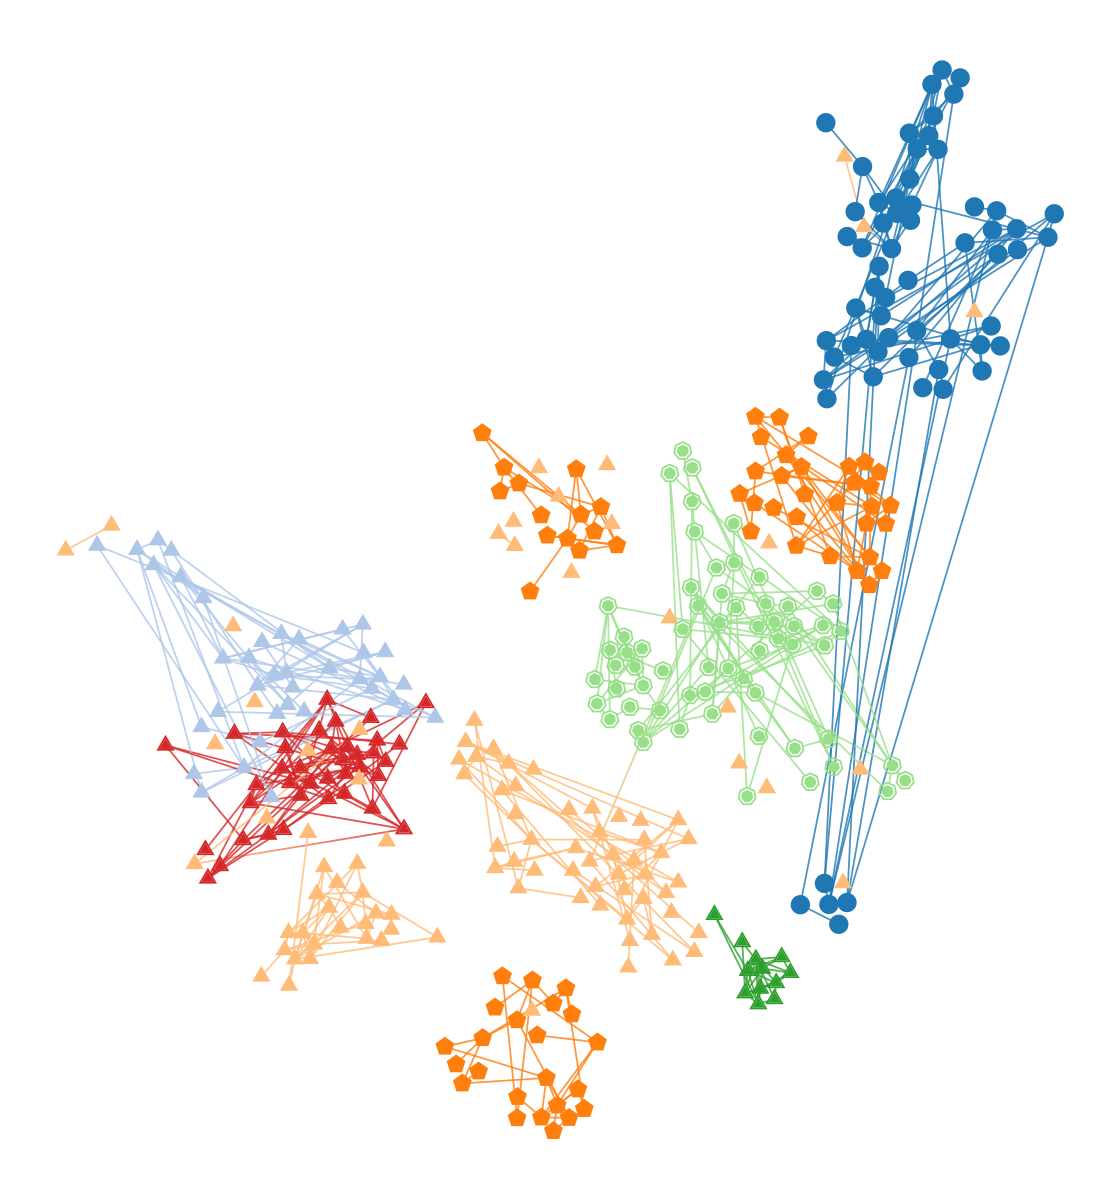

0.5
0.6649076517150396
13348 836 914
<Graph object, undirected, with 379 vertices and 735 edges, at 0x30da2f330>


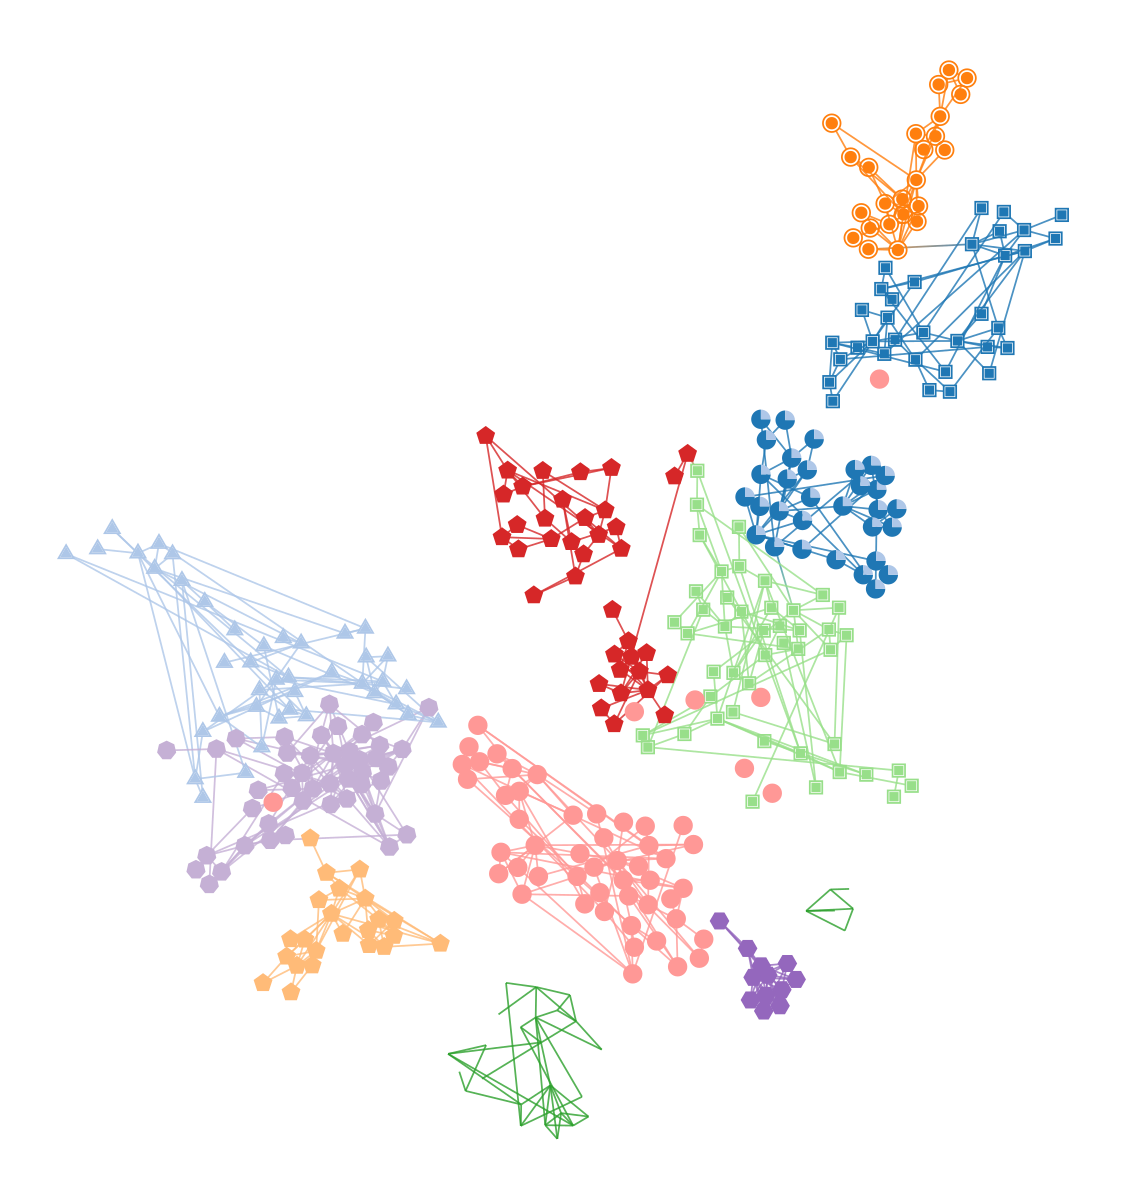

2.5
0.9234828496042217
107512 1689 914
<Graph object, undirected, with 379 vertices and 755 edges, at 0x17fe0f6b0>


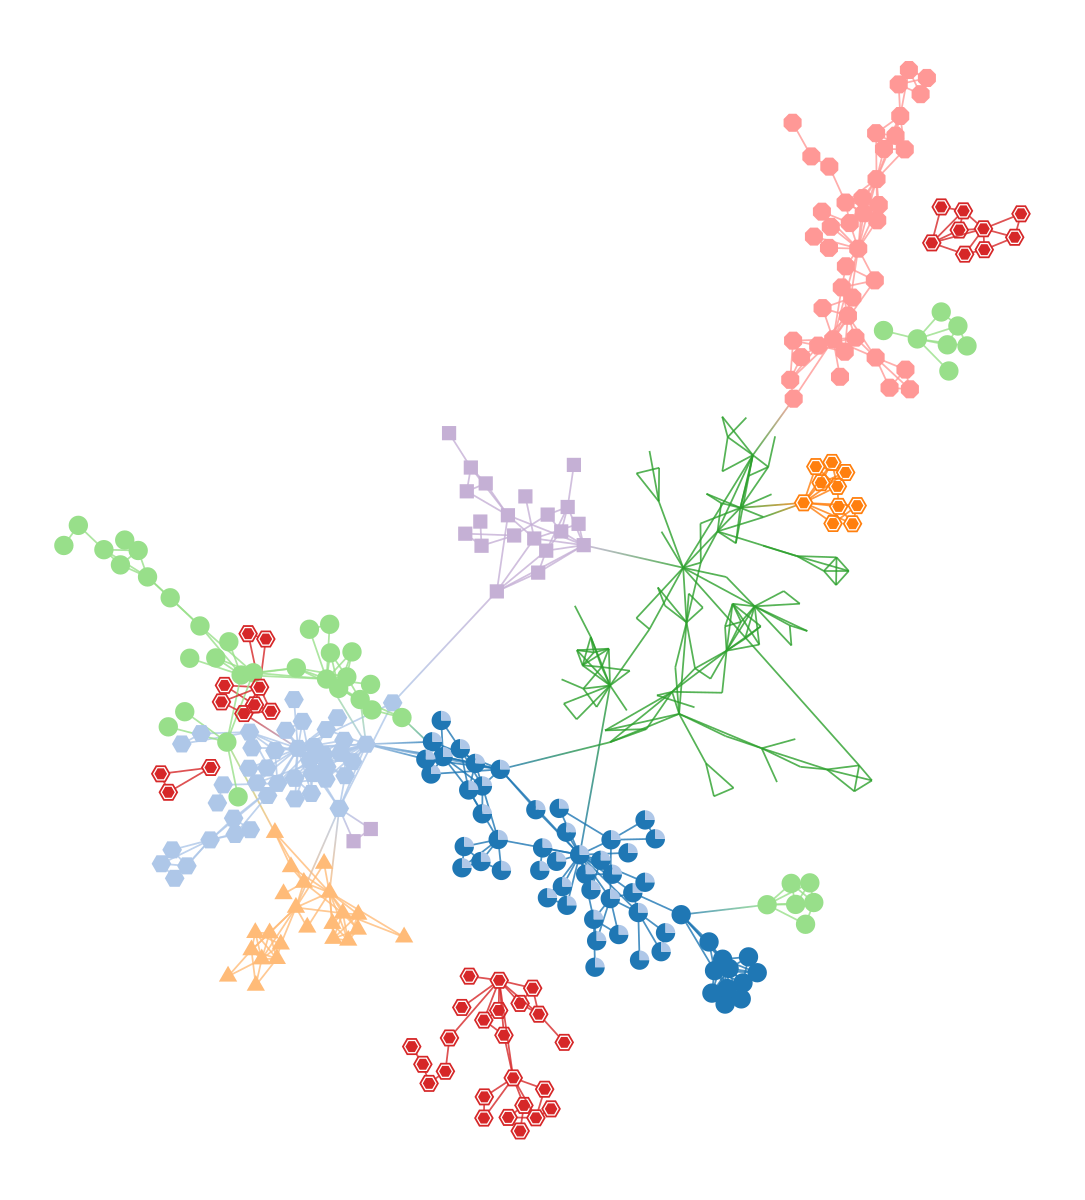

7.5
0.7440633245382586


In [13]:
# nous EXPERIMENT Sparse :))
      # https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#inferring-the-best-partition

for epsilon in [0.5 ,2.5 ,7.5]:

    MG = add_SBM(adj_matrix, block_list, density_matrix, epsilon)
    NoisyG = coo_matrix_to_graphtool(MG)
    print(NoisyG)

    # # plot modified graph
    stateN = minimize_blockmodel_dl(NoisyG,  multilevel_mcmc_args={'niter':2})
    stateN.draw(pos=pos, vertex_shape=stateN.get_blocks())

    print(epsilon)
    # metrics
    print(graph_tool.inference.partition_overlap(state.get_blocks().a, stateN.get_blocks().a, norm=True))
    # print(graph_tool.inference.mutual_information(state.get_blocks().a, stateN.get_blocks().a, norm=True))


# Robustness

In [17]:
# EXPERIMENTS ROBUSTNESS

# Inference of blockstate
# names = ['polblogs', 'netscience', 'power']
names = ['power']
dict_datasets = {}

for name in names:
    G = collection.data[name]
    G = extract_largest_component(G, prune=True)

    remove_parallel_edges(G)
    remove_self_loops(G)
    G= GraphView(G, directed=False)

    dict_exp = {}
    for i in range(1):
        state = minimize_blockmodel_dl(G,  multilevel_mcmc_args={'niter':2})
        b = contiguous_map(state.get_blocks())
        state = state.copy(b=b)
        block_list = state.get_blocks().a
        adj_matrix = get_coo_matrix(G)
        density_matrix = calc_all_densities(adj_matrix, block_list)

        dict_iter = {}
        for j in range(1):
            dict_overlap = {}
            for epsilon in  np.arange(0.25, 2.1, 0.25):

                MG = add_SBM(adj_matrix, block_list, density_matrix, epsilon)
                NoisyG = coo_matrix_to_graphtool(MG)
                stateN = minimize_blockmodel_dl(NoisyG,  multilevel_mcmc_args={'niter':2})

                print(epsilon, graph_tool.inference.partition_overlap(state.get_blocks().a, stateN.get_blocks().a, norm=True))
                dict_overlap[epsilon] = graph_tool.inference.partition_overlap(state.get_blocks().a, stateN.get_blocks().a, norm=True)

            dict_iter[j] = dict_overlap
            print(j, 'iteration done')
        dict_exp[i] = dict_iter
        print(i, 'experiment done')
    dict_datasets[name] = dict_exp

16530 69 6594
0.25 0.15138635903663225
21170 80 6594
0.5 0.15138635903663225
27244 93 6594
0.75 0.15138635903663225
34832 133 6594
1.0 0.15138635903663225
44646 161 6594
1.25 0.15138635903663225
57160 222 6594
1.5 0.15138635903663225
73066 257 6594
1.75 0.15138635903663225
93352 328 6594
2.0 0.15138635903663225
0 iteration done
0 experiment done


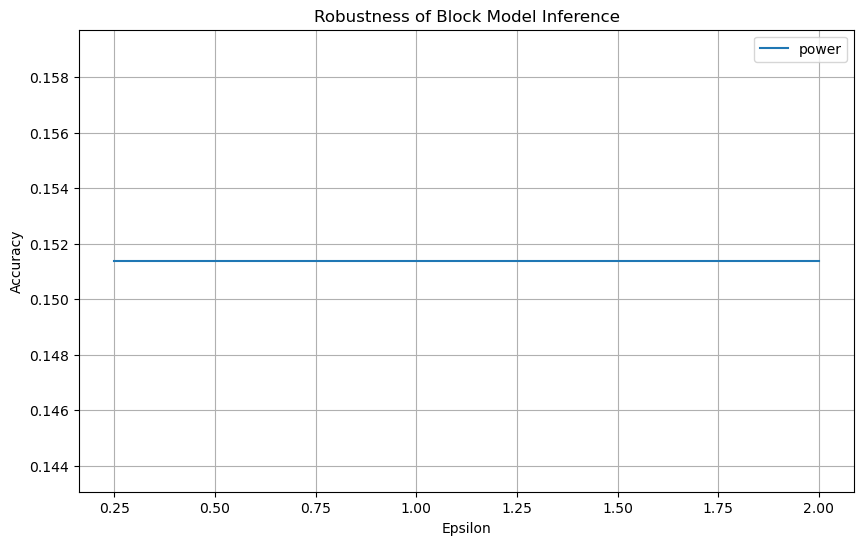

In [19]:
def plot_robustness(dict_datasets):
    plt.figure(figsize=(10, 6))  # Create a single figure for all plots
    for name in dict_datasets:
        data_points = []
    for i in range(1):  # Iterate through the experiments
        for j in range(1): #Iterate through the iterations
            for epsilon, overlap in dict_datasets[name][i][j].items():
                data_points.append({"dataset": name, "experiment": i, "iteration": j,"epsilon": epsilon, "overlap": overlap})

    df = pd.DataFrame(data_points)
    sns.lineplot(x="epsilon", y="overlap", data=df, label=name, markers=True, errorbar="sd") # Use label instead of hue

    plt.title("Robustness of Block Model Inference") # Combined title
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend() # Show legend for all datasets
    plt.show()

# Call the plotting function
plot_robustness(dict_datasets)

# Experiment to compare with Privgraph

In [31]:
!python main_meu.py

Dataset:Chamelon
Node number:2277
Edge number:31371
time_louvain 0.17277908325195312
time_EVC 0.13936877250671387
time_ClustC 0.27576398849487305
time_density 0.03052687644958496
-----------epsilon=0.5,exper=1/3-------------
182384 25354 62742
time_SBM 0.3282051086425781
Nodes=2277,Edges=33264,nmi=0.9325,cc_rel=0.3240,deg_kl=1.5721,mod_rel=0.0266,evc_overlap=0.6364,evc_MAE=0.0268
-----------epsilon=0.5,exper=2/3-------------
182384 25876 62742
time_SBM 0.33974695205688477
Nodes=2277,Edges=33475,nmi=0.9340,cc_rel=0.3173,deg_kl=1.5949,mod_rel=0.0274,evc_overlap=0.7273,evc_MAE=0.0267
-----------epsilon=0.5,exper=3/3-------------
182384 25502 62742
time_SBM 0.32822084426879883
Nodes=2277,Edges=33318,nmi=0.9975,cc_rel=0.3200,deg_kl=1.4292,mod_rel=0.0083,evc_overlap=0.5909,evc_MAE=0.0274
all_index=1/7 Done.3.82s

-----------epsilon=1.0,exper=1/3-------------
267576 35148 62742
time_SBM 0.41082072257995605
Nodes=2277,Edges=34033,nmi=0.9350,cc_rel=0.2292,deg_kl=1.2764,mod_rel=0.0252,evc_overla

In [28]:
!python main.py

Dataset:Chamelon
Node number:2277
Edge number:31371
-----------epsilon=0.5,exper=1/10-------------
Nodes=2277,Edges=23763,nmi=0.1126,cc_rel=0.8312,deg_kl=2.1902,mod_rel=0.5786,evc_overlap=0.1364,evc_MAE=0.0252,diam_rel=0.5455
/Users/ncvg3/Downloads/SBM_Noise/main.py:248: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, data1], ignore_index=True)
-----------epsilon=0.5,exper=2/10-------------
Nodes=2277,Edges=24886,nmi=0.0866,cc_rel=0.8653,deg_kl=2.0841,mod_rel=0.5786,evc_overlap=0.0000,evc_MAE=0.0340,diam_rel=0.5455
-----------epsilon=0.5,exper=3/10-------------
Nodes=2277,Edges=22274,nmi=0.1129,cc_rel=0.8541,deg_kl=2.6300,mod_rel=0.6144,evc_overlap=0.4091,evc_MAE=0.0188,diam_rel=0.5455
-----------epsilon=0.5,ex

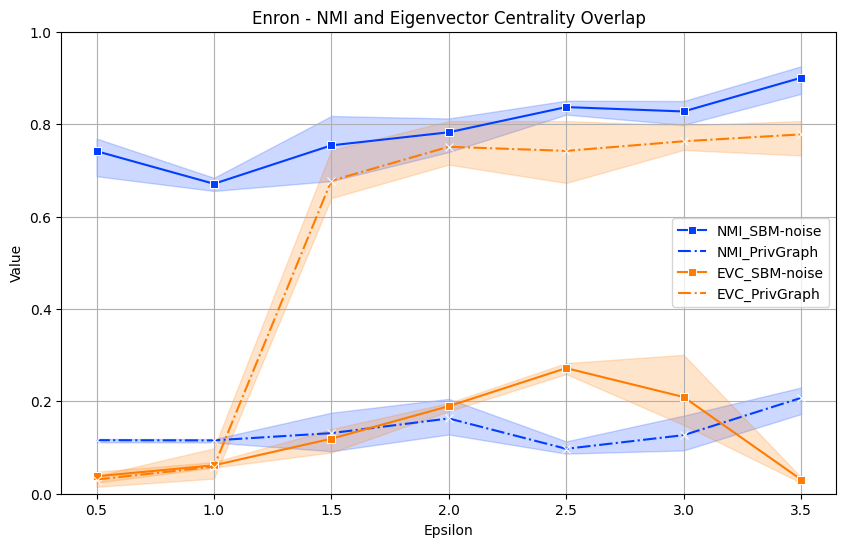

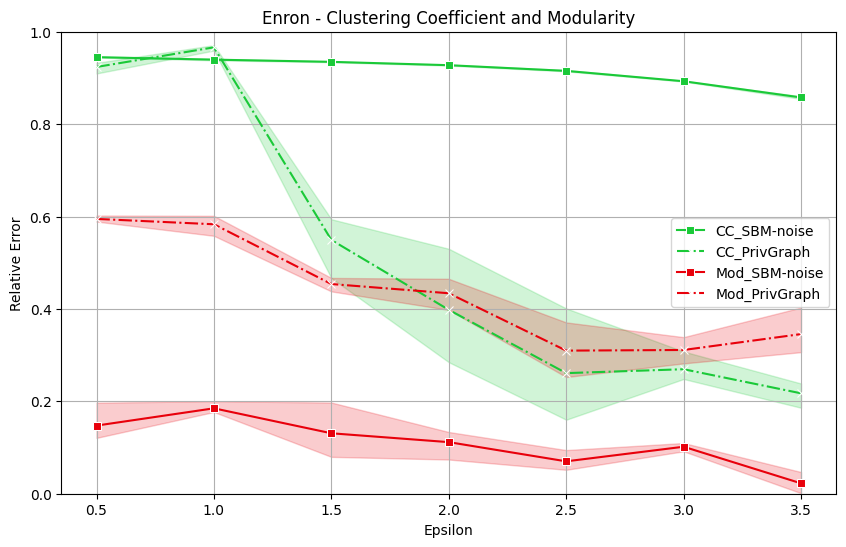

In [ ]:
# PLOTS

name = 'Enron' # 'CA-HepPh' # 'Facebook' # 'Chamelon' #
df = pd.read_csv('/content/PrivGraph/result/%s_20_1.0_0.33_0.33_3.csv'%(name))
# Load the data from the CSV file into a pandas DataFrame.
df_new = pd.read_csv('/content/PrivGraph/result/%s_3.csv'%name)

color_palette = sns.color_palette("bright")

# Assuming the previous plot's data is stored in 'df'

# Create the line plot using seaborn, combining data from both DataFrames
plt.figure(figsize=(10, 6))

# Plot data
sns.lineplot(x='eps', y='nmi', data=df_new, label='NMI_SBM-noise', marker='s', color=color_palette[0])
sns.lineplot(x='eps', y='nmi', data=df, label='NMI_PrivGraph', marker='x', linestyle='dashdot', color=color_palette[0])

sns.lineplot(x='eps', y='evc_overlap', data=df_new, label='EVC_SBM-noise', marker='s', color=color_palette[1])
sns.lineplot(x='eps', y='evc_overlap', data=df, label='EVC_PrivGraph', marker='x', linestyle='dashdot', color=color_palette[1])

# Customize the plot
plt.xlabel('Epsilon')
plt.ylabel('Value')
plt.title('%s - NMI and Eigenvector Centrality Overlap'%(name))
plt.legend(loc='center right')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

##
plt.figure(figsize=(10, 6))

# Plot data from the original 'df'
sns.lineplot(x='eps', y='cc_rel', data=df_new, label='CC_SBM-noise', marker='s', color=color_palette[2])
sns.lineplot(x='eps', y='cc_rel', data=df, label='CC_PrivGraph', marker='x', linestyle='dashdot', color=color_palette[2])
sns.lineplot(x='eps', y='mod_rel', data=df_new, label='Mod_SBM-noise', marker='s', color=color_palette[3])
sns.lineplot(x='eps', y='mod_rel', data=df, label='Mod_PrivGraph', marker='x', linestyle='dashdot', color=color_palette[3])

# Customize the plot
plt.xlabel('Epsilon')
plt.ylabel('Relative Error')
plt.title('%s - Clustering Coefficient and Modularity'%(name))
plt.legend(loc='center right')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Experiments "private-spectral-clustering"

In [21]:
names_dict = {
    'polblogs': {
        'folder': 'political_blogs',
        'edge_file': 'blogs.txt',
        'label_file': 'blogs-orientation.txt'
    },
    'fb_simmons': {
        'folder': 'fb100',
        'edge_file': 'simmons-edges.txt',
        'label_file': 'simmons-nodes.txt'
    },
}

datasets_dict = {}

for dataset in names_dict:
    url = f"https://raw.githubusercontent.com/jonhehir/private-spectral-clustering/master/datasets/{names_dict[dataset]['folder']}/{names_dict[dataset]['label_file']}"
    response = requests.get(url)
    response.raise_for_status()

    communities = np.genfromtxt(io.StringIO(response.text),
                             dtype=str)

    url = f"https://raw.githubusercontent.com/jonhehir/private-spectral-clustering/master/datasets/{names_dict[dataset]['folder']}/{names_dict[dataset]['edge_file']}"
    response = requests.get(url)
    response.raise_for_status()


    edgelist = np.genfromtxt(io.StringIO(response.text),
                             dtype=int,
                             comments='%',
                             )

    M = sparse.coo_matrix((np.ones(edgelist.shape[0]*2),
                        (list(edgelist[:, 0]) + list(edgelist[:, 1]),
                            list(edgelist[:,1]) + list(edgelist[:,0])
                            )
                        ))

    datasets_dict[dataset] = {'edges': M, 'partition': communities}

In [23]:
def label_accuracy(labels, truth):
    """
    max(accuracy) over the set of all label permutations
    truth should be an list of 0-indexed integer labels of length n
    """
    accuracy = 0
    k = max(truth) + 1 # number of labels

    # This is not optimal, but we're using small k, so it's no biggie.
    for p in itertools.permutations(range(k)):
        compare = [p[t] for t in truth]
        accuracy = max(accuracy, metrics.accuracy_score(labels, compare))

    return accuracy

def normalize_rows(U):
    """
    Normalize rows of U to have unit norm
    If a given row has norm == 0, it is left alone
    """
    n = U.shape[0]
    row_norms = np.linalg.norm(U, axis=1).reshape((n, 1))

    # safely divide by norms, leaving original entries if row norm == 0
    return np.divide(U, row_norms, out=U, where=(row_norms > 0))

N_KMEDIANS_INITIALIZATIONS = 10
def cluster_normalized_kmedians(U, k):
    """
    Cluster U by k-medians over row-normalized version of U
    Return labels
    """
    n = U.shape[0]
    U_norm = normalize_rows(U)
    best_labels = None
    best_error = float("inf")

    # Run k-medians multiple times with random initializations, then return best result
    for i in range(N_KMEDIANS_INITIALIZATIONS):
        # for initial centers, choose k points at random
        indices = np.random.choice(n, k, replace=False)
        initial_centers = U_norm[indices, :]

        # run k-medians
        instance = kmedians(U_norm.tolist(), initial_centers.tolist())
        instance.process()

        # get cluster labels (in the format we want them)
        labels = [None] * n
        i = 0
        for c in instance.get_clusters():
            for j in c:
                labels[j] = i
            i += 1

        # calculate error
        medians = np.array(instance.get_medians())
        error = np.sum(np.linalg.norm(U_norm - medians[labels, :], axis=1))

        if error < best_error:
            best_labels = labels
            best_error = error

    return best_labels

def cluster_kmeans(U, k):
    """
    Cluster U by simple k-means
    Return labels
    """
    kmeans = cluster.KMeans(n_clusters=k)
    return kmeans.fit(U).labels_


def recover_labels(A, k, strategy=cluster_kmeans):
    """
    Employ spectral clustering to recover labels for A
    """
    A = A.astype(np.float64)
    U = sparse.linalg.eigsh(A, k)[1]
    return strategy(U, k)

## Experiment "private-spectral-clustering"

In [25]:
# nous EXPERIMENTS "private-spectral-clustering"
exp_list = {dataset: [] for dataset in datasets_dict}
df_dict = {}

for i in range(5):   #5
    for dataset in datasets_dict:
        G = coo_matrix_to_graphtool(datasets_dict[dataset]['edges'])
        v_degrees = G.degree_property_map("total")
        nodes_to_remove = [v for v in G.vertices() if v_degrees[v] == 0]
        G.remove_vertex(nodes_to_remove)

        # convert to categories
        categorical_communities = pd.Series(datasets_dict[dataset]['partition']).astype('category')
        truth = categorical_communities.cat.codes
        k = len(np.unique(truth))  # number of communities

        ###########

        adj_matrix_symmetric = get_coo_matrix(G, symmetric=True)
        adj_matrix_symmetric = adj_matrix_symmetric.astype(np.float64)

        labels = recover_labels(adj_matrix_symmetric, k, strategy=cluster_normalized_kmedians)
        accuracy = label_accuracy(labels, truth)
        print('base_accuracy', accuracy)

        block_list = labels
        density_matrix = calc_all_densities(adj_matrix_symmetric, block_list)

        print(G)

        added_edges = []
        removed_edges = []
        accuracy_data = []

        epsilon_values = np.arange(0.25, 2.1, 0.25)
        for epsilon in epsilon_values:

            MG = add_SBM(adj_matrix_symmetric, block_list, density_matrix, epsilon)
            NoisyG = coo_matrix_to_graphtool(MG)

            print(NoisyG)
            print('epsilon:', epsilon)

            # metrics
            A_noisy_symmetric = get_coo_matrix(NoisyG, symmetric=True)
            A_noisy_symmetric = A_noisy_symmetric.astype(np.float64)

            labels = recover_labels(A_noisy_symmetric, k, strategy=cluster_normalized_kmedians)
            accuracy = label_accuracy(labels, truth)
            accuracy_data.append(accuracy)
            print('Spectral_accuracy', accuracy)

            M = adj_matrix_symmetric - A_noisy_symmetric
            unique, counts = np.unique(M.data, return_counts=True)

            print(unique, counts/2)
            added_edges.append(counts[0]/2)
            removed_edges.append(counts[1]/2)

        data = {'epsilon': epsilon_values, 'added': added_edges, 'removed': removed_edges, 'accuracy': accuracy_data}
        df_dict[dataset] = pd.DataFrame(data)
        exp_list[dataset].append(df_dict[dataset])

    print("finished iteration", i)

base_accuracy 0.9468954248366013
<Graph object, undirected, with 1224 vertices and 16715 edges, at 0x31e71e5d0>
81772 3286.0 33430.0


KeyboardInterrupt: 

In [ ]:
# Create a list to store the results for each dataset
results = []

# Iterate over the datasets
for dataset, df_list in exp_list.items():
  df = pd.concat(df_list)

  # Calculate the average values for each epsilon
  avg_accuracy_epsilon = df.groupby('epsilon')['accuracy'].mean().reset_index()
  avg_added_epsilon = df.groupby('epsilon')['added'].mean().reset_index()
  avg_removed_epsilon = df.groupby('epsilon')['removed'].mean().reset_index()

  # Merge the average values into a single DataFrame
  merged_df = pd.merge(avg_accuracy_epsilon, avg_added_epsilon, on='epsilon')
  merged_df = pd.merge(merged_df, avg_removed_epsilon, on='epsilon')

  # Add dataset name to the table
  merged_df['dataset'] = dataset
  results.append(merged_df)

# Concatenate the results for all datasets into a single table
final_table = pd.concat(results)

# Display the table
print("Average Accuracy, Added, and Removed Edges for each Epsilon and Dataset:")
final_table

Average Accuracy, Added, and Removed Edges for each Epsilon and Dataset:


,epsilon,accuracy,added,removed,dataset
0,0.25,0.946895,15616.8,15162.4,polblogs
1,0.50,0.946895,15420.8,14742.2,polblogs
2,0.75,0.946895,15057.6,14324.0,polblogs
3,1.00,0.946895,14716.0,13736.8,polblogs
4,1.25,0.946895,14450.0,13165.2,polblogs
5,1.50,0.946895,13918.0,12379.2,polblogs
6,1.75,0.946895,13392.0,11608.0,polblogs
7,2.00,0.946895,12780.8,10787.0,polblogs
0,0.25,0.766667,21049.8,20231.2,fb_simmons
1,0.50,0.768221,20515.6,19358.2,fb_simmons


In [ ]:
# Separate dataframes for polblogs and fb_simmons
polblogs_df = final_table[final_table['dataset'] == 'polblogs'].copy()
fb_simmons_df = final_table[final_table['dataset'] == 'fb_simmons'].copy()

# Divide added and removed edges by the respective constants
polblogs_df['added'] = polblogs_df['added'] / 16715
polblogs_df['removed'] = polblogs_df['removed'] / 16715

fb_simmons_df['added'] = fb_simmons_df['added'] / 24449
fb_simmons_df['removed'] = fb_simmons_df['removed'] / 24449

# Display the modified DataFrames
print("Polblogs DataFrame:")
print(polblogs_df)

print("\nFB Simmons DataFrame:")
fb_simmons_df

Polblogs DataFrame:
   epsilon  accuracy     added   removed   dataset
0     0.25  0.946895  0.934299  0.907113  polblogs
1     0.50  0.946895  0.922573  0.881974  polblogs
2     0.75  0.946895  0.900844  0.856955  polblogs
3     1.00  0.946895  0.880407  0.821825  polblogs
4     1.25  0.946895  0.864493  0.787628  polblogs
5     1.50  0.946895  0.832665  0.740604  polblogs
6     1.75  0.946895  0.801197  0.694466  polblogs
7     2.00  0.946895  0.764631  0.645348  polblogs

FB Simmons DataFrame:


,epsilon,accuracy,added,removed,dataset
0,0.25,0.766667,0.860968,0.827486,fb_simmons
1,0.50,0.768221,0.839118,0.791779,fb_simmons
2,0.75,0.767530,0.813277,0.753806,fb_simmons
3,1.00,0.767358,0.779901,0.713076,fb_simmons
4,1.25,0.769085,0.744808,0.665050,fb_simmons
5,1.50,0.768912,0.705681,0.621089,fb_simmons
6,1.75,0.768048,0.657925,0.574813,fb_simmons
7,2.00,0.768566,0.613113,0.531048,fb_simmons


In [ ]:
fb_simmons_df.to_latex(index=False)

'\\begin{tabular}{rrrrl}\n\\toprule\nepsilon & accuracy & added & removed & dataset \\\\\n\\midrule\n0.250000 & 0.766667 & 0.860968 & 0.827486 & fb_simmons \\\\\n0.500000 & 0.768221 & 0.839118 & 0.791779 & fb_simmons \\\\\n0.750000 & 0.767530 & 0.813277 & 0.753806 & fb_simmons \\\\\n1.000000 & 0.767358 & 0.779901 & 0.713076 & fb_simmons \\\\\n1.250000 & 0.769085 & 0.744808 & 0.665050 & fb_simmons \\\\\n1.500000 & 0.768912 & 0.705681 & 0.621089 & fb_simmons \\\\\n1.750000 & 0.768048 & 0.657925 & 0.574813 & fb_simmons \\\\\n2.000000 & 0.768566 & 0.613113 & 0.531048 & fb_simmons \\\\\n\\bottomrule\n\\end{tabular}\n'

# repeat Spectral Clustering results


In [ ]:
!git clone https://github.com/jonhehir/private-spectral-clustering
%cd /content/private-spectral-clustering/


Cloning into 'private-spectral-clustering'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 494 (delta 2), reused 2 (delta 2), pack-reused 487 (from 1)
Receiving objects: 100% (494/494), 7.03 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (245/245), done.
/content/private-spectral-clustering


In [ ]:
!pip install pyclustering

import itertools
from sklearn import cluster, metrics
import pyclustering


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395099 sha256=dee110c85d9319b9dd45961239a12c1024668a98a83f0eb62376e6a6d2881a8a
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [ ]:
from pyclustering.cluster.kmedians import kmedians # Import the kmedians function
import numpy as np
from scipy import sparse, stats

# Functions from "private-spectral-clustering"
def generate_block(size, prob, symmetric=False):
    return generate_sparse_block(size, prob, symmetric=symmetric).toarray()


def generate_sparse_block(size, prob, symmetric=False):
    """
    Generates a random block of binary entries where each entry is 1 w.p. prob
    If symmetric=True, returns a symmetric block with a zero on the diagonal.
    """
    density = stats.binom.rvs(size[0] * size[1], prob, size=1).item() / (size[0] * size[1])
    m = sparse.random(size[0], size[1], density)
    m.data[:] = 1

    if symmetric:
        if size[0] != size[1]:
            raise RuntimeError("symmetric matrix must be square")
        m = sparse.triu(m, k=1) + sparse.triu(m, k=1).transpose()

    return m

# Hardcoded number of random initializations to try for k-medians
N_KMEDIANS_INITIALIZATIONS = 10

def cluster_kmeans(U, k):
    """
    Cluster U by simple k-means
    Return labels
    """
    kmeans = cluster.KMeans(n_clusters=k)
    return kmeans.fit(U).labels_

def recover_labels(A, k, strategy=cluster_kmeans):
    """
    Employ spectral clustering to recover labels for A
    """
    U = sparse.linalg.eigsh(A, k)[1]
    return strategy(U, k)

def normalize_rows(U):
    """
    Normalize rows of U to have unit norm
    If a given row has norm == 0, it is left alone
    """
    n = U.shape[0]
    row_norms = np.linalg.norm(U, axis=1).reshape((n, 1))

    # safely divide by norms, leaving original entries if row norm == 0
    return np.divide(U, row_norms, out=U, where=(row_norms > 0))

def cluster_normalized_kmedians(U, k):
    """
    Cluster U by k-medians over row-normalized version of U
    Return labels
    """
    n = U.shape[0]
    U_norm = normalize_rows(U)
    best_labels = None
    best_error = float("inf")

    # Run k-medians multiple times with random initializations, then return best result
    for i in range(N_KMEDIANS_INITIALIZATIONS):
        # for initial centers, choose k points at random
        indices = np.random.choice(n, k, replace=False)
        initial_centers = U_norm[indices, :]

        # run k-medians
        instance = kmedians(U_norm.tolist(), initial_centers.tolist())
        instance.process()

        # get cluster labels (in the format we want them)
        labels = [None] * n
        i = 0
        for c in instance.get_clusters():
            for j in c:
                labels[j] = i
            i += 1

        # calculate error
        medians = np.array(instance.get_medians())
        error = np.sum(np.linalg.norm(U_norm - medians[labels, :], axis=1))

        if error < best_error:
            best_labels = labels
            best_error = error

    return best_labels

def label_accuracy(labels, truth):
    """
    max(accuracy) over the set of all label permutations
    truth should be an list of 0-indexed integer labels of length n
    """
    accuracy = 0
    k = max(truth) + 1 # number of labels

    # This is not optimal, but we're using small k, so it's no biggie.
    for p in itertools.permutations(range(k)):
        compare = [p[t] for t in truth]
        accuracy = max(accuracy, metrics.accuracy_score(labels, compare))

    return accuracy

def preprocess_recenter(M, eps):
    """
    Subtracts 1/(e^eps + 1) from off-diagonals of M
    """
    p = perturb_prob(eps)
    return M - p + np.diag([p] * M.shape[0])


def perturb_prob(eps):
    """
    P(perturb edge)
    """
    return 1 / (np.exp(eps) + 1)


def perturb_symmetric(m, eps):
    """
    Perturb a symmetric adjacency matrix using edge flips
    Note: This retains a zero on the diagonal.
    """
    p = perturb_prob(eps)
    error = generate_block(m.shape, p, symmetric = True)
    return abs(m - error)


# REPEAT EXPERIMENTS "private-spectral-clustering"
exp_list = {dataset: [] for dataset in datasets_dict}
df_dict = {}

for i in range(5):   #5
    for dataset in datasets_dict:
        G = coo_matrix_to_graphtool(datasets_dict[dataset]['edges'])
        v_degrees = G.degree_property_map("total")
        nodes_to_remove = [v for v in G.vertices() if v_degrees[v] == 0]
        G.remove_vertex(nodes_to_remove)


        # convert to categories
        categorical_communities = pd.Series(datasets_dict[dataset]['partition']).astype('category')
        truth = categorical_communities.cat.codes
        k = len(np.unique(truth))  # number of communities

        ###########

        adj_matrix_symmetric = get_coo_matrix(G, symmetric=True)
        adj_matrix_symmetric = adj_matrix_symmetric.astype(np.float64)
        # adj_matrix = get_coo_matrix(G) #adjacency(G)


        labels = recover_labels(adj_matrix_symmetric, k, strategy=cluster_normalized_kmedians)
        accuracy = label_accuracy(labels, truth)
        print('base_accuracy', accuracy)


        block_list = labels

        print(G)

        added_edges = []
        removed_edges = []
        accuracy_data = []

        epsilon_values = np.arange(0.25, 2.1, 0.25)
        for epsilon in epsilon_values:

            if epsilon >= 0:
               A = preprocess_recenter(perturb_symmetric(adj_matrix_symmetric, epsilon), epsilon)

            labels = recover_labels(A, k, strategy=cluster_normalized_kmedians)

            print('epsilon:', epsilon)

            # metrics
            A_noisy_symmetric = A

            labels = recover_labels(A_noisy_symmetric, k, strategy=cluster_normalized_kmedians)
            accuracy = label_accuracy(labels, truth)
            accuracy_data.append(accuracy)
            print('Spectral_accuracy', accuracy)

            M = adj_matrix_symmetric - A_noisy_symmetric
            unique, counts = np.unique(M.data, return_counts=True)

            print(unique, counts/2)
            added_edges.append(counts[0]/2)
            removed_edges.append(counts[1]/2)

        data = {'epsilon': epsilon_values, 'added': added_edges, 'removed': removed_edges, 'accuracy': accuracy_data}

        df_dict[dataset] = pd.DataFrame(data)

        exp_list[dataset].append(df_dict[dataset])


    print("finished iteration", i)

base_accuracy 0.9477124183006536
<Graph object, undirected, with 1224 vertices and 16715 edges, at 0x7817477f6860>
epsilon: 0.25
Spectral_accuracy 0.5228758169934641
[-0.5621765  0.         0.4378235  1.4378235] [320112.    612. 420970.   7394.]
epsilon: 0.5
Spectral_accuracy 0.5130718954248366
[-0.62245933  0.          0.37754067  1.37754067] [276194.    612. 466113.   6169.]
epsilon: 0.75
Spectral_accuracy 0.6748366013071896
[-0.6791787  0.         0.3208213  1.3208213] [235332.    612. 507727.   5417.]
epsilon: 1.0
Spectral_accuracy 0.704248366013072
[-0.73105858  0.          0.26894142  1.26894142] [196779.    612. 547226.   4471.]
epsilon: 1.25
Spectral_accuracy 0.7630718954248366
[-0.77729986  0.          0.22270014  0.22270014  1.22270014] [162492.    612.  12977. 569269.   3738.]
epsilon: 1.5
Spectral_accuracy 0.7655228758169934
[-0.81757448  0.          0.18242552  1.18242552] [133749.    612. 611680.   3047.]
epsilon: 1.75
Spectral_accuracy 0.7933006535947712
[-0.8519528  0. 

In [ ]:
exp_list

{'polblogs': [   epsilon     added  removed  accuracy
  0     0.25  320112.0    612.0  0.522876
  1     0.50  276194.0    612.0  0.513072
  2     0.75  235332.0    612.0  0.674837
  3     1.00  196779.0    612.0  0.704248
  4     1.25  162492.0    612.0  0.763072
  5     1.50  133749.0    612.0  0.765523
  6     1.75  108623.0    612.0  0.793301
  7     2.00   87379.0    612.0  0.807190,
     epsilon     added  removed  accuracy
  0     0.25  321127.0    612.0  0.503268
  1     0.50  276184.0    612.0  0.508987
  2     0.75  234623.0    612.0  0.659314
  3     1.00  197062.0    612.0  0.708333
  4     1.25  162880.0    612.0  0.750817
  5     1.50  133969.0    612.0  0.773693
  6     1.75  108738.0    612.0  0.778595
  7     2.00   87053.0    612.0  0.811275,
     epsilon     added  removed  accuracy
  0     0.25  321123.0    612.0  0.502451
  1     0.50  276855.0    612.0  0.569444
  2     0.75  235015.0    612.0  0.645425
  3     1.00  197256.0    612.0  0.726307
  4     1.25  162816

In [ ]:
# Create a list to store the results for each dataset
results = []

# Iterate over the datasets
for dataset, df_list in exp_list.items():
  df = pd.concat(df_list)

  avg_accuracy_epsilon = df.groupby('epsilon')['accuracy'].mean().reset_index()

  # Add dataset name to the table
  avg_accuracy_epsilon['dataset'] = dataset
  results.append(avg_accuracy_epsilon)

# Concatenate the results for all datasets into a single table
avg_accuracy_table = pd.concat(results)

# Display the table with average accuracy for each epsilon and dataset
print("Average Accuracy for each Epsilon and Dataset:")
print(avg_accuracy_table)


Average Accuracy for each Epsilon and Dataset:
   epsilon  accuracy     dataset
0     0.25  0.512418    polblogs
1     0.50  0.532516    polblogs
2     0.75  0.665523    polblogs
3     1.00  0.687745    polblogs
4     1.25  0.744771    polblogs
5     1.50  0.770588    polblogs
6     1.75  0.785131    polblogs
7     2.00  0.801144    polblogs
0     0.25  0.274439  fb_simmons
1     0.50  0.286701  fb_simmons
2     0.75  0.358549  fb_simmons
3     1.00  0.444732  fb_simmons
4     1.25  0.540760  fb_simmons
5     1.50  0.613126  fb_simmons
6     1.75  0.656477  fb_simmons
7     2.00  0.670639  fb_simmons


## Metrics

In [ ]:
graph_tool.inference.partition_overlap(state.get_blocks().a, stateN.get_blocks().a, norm=True)


## Pot servir per altra cosa

In [ ]:
# prompt: change labels of propertyarray to their ranks

import numpy as np

# Assuming 'block_list' is your array with block labels
# and you want to replace labels with their ranks.
def rank_labels(block_list):
    unique_labels = np.unique(block_list)
    label_to_rank = {label: rank for rank, label in enumerate(unique_labels)}

    new_block_list = [label_to_rank[label] for label in block_list]

# Now 'new_block_list' contains the ranks of the original labels.
    return(new_block_list)


In [ ]:
# prompt: represent state.get_blocks().a and stateN.get_blocks().a with the same vector

import numpy as np

def align_block_vectors(state, stateN):
  """Aligns the block vectors of two BlockState objects.

  Args:
    state: The first BlockState object.
    stateN: The second BlockState object.

  Returns:
    A tuple containing the aligned block vectors for state and stateN.
    Returns None if the block vectors cannot be aligned.
  """
  blocks_state = state.get_blocks().a
  blocks_stateN = stateN.get_blocks().a

  if len(blocks_state) != len(blocks_stateN):
    print("Error: Block vectors have different lengths.")
    return None

  # Find a permutation of stateN's block labels to best match state's labels
  unique_labels_state = np.unique(blocks_state)
  unique_labels_stateN = np.unique(blocks_stateN)

  if len(unique_labels_state) != len(unique_labels_stateN):
    print("Error: Different number of unique block labels")
    return None

  mapping = {label_stateN: label_state for label_state, label_stateN in zip(unique_labels_state, unique_labels_stateN)}

  aligned_blocks_stateN = np.array([mapping[label] for label in blocks_stateN])
  return blocks_state, aligned_blocks_stateN

In [ ]:
G = collection.data['polbooks']  # ['polblogs']  # ['netscience'] #
# G = extract_largest_component(G, prune=True)

remove_parallel_edges(G)
remove_self_loops(G)

coloring = sequential_vertex_coloring(G)
print(coloring.a)

block_list = coloring.get_array()

for epsilon in np.arange(0.25, 2.1, 0.25):

    MG = block_LDP(adj_matrix, block_list, epsilon)
    NoisyG = coo_matrix_to_graphtool(MG)

    print(NoisyG)

    coloringN = sequential_vertex_coloring(NoisyG)
    print(np.unique(coloring.a))
    print(epsilon)
    # metrics
    print(graph_tool.inference.mutual_information(coloring.a, coloringN.a, norm=True))